In [19]:
import torch

In [20]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True, force_reload=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to C:\Users\91998/.cache\torch\hub\v0.9.0.zip


In [21]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [22]:
for name, param in model.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

for name, param in model.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

In [23]:
num_classes = 2

In [24]:
model.fc = nn.Sequential(nn.Linear(model.fc.in_features,512),
                         nn.ReLU(),
                         nn.Dropout(),
                         nn.Linear(512, num_classes))

In [25]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device = "cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print("Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}".format(epoch,
        training_loss,
        valid_loss, num_correct / num_examples))

Wall time: 0 ns


In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [27]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
batch_size=32
img_dimensions = 224

In [29]:
img_transforms = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225] )])

img_test_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225] )
])

In [30]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [31]:
train_data_path = "../datasets/sheep_goat_classification/class_wise/train"
train_data = torchvision.datasets.ImageFolder(
    root=train_data_path,
    transform=img_transforms)

validation_data_path = "../datasets/sheep_goat_classification/class_wise/test"
validation_data = torchvision.datasets.ImageFolder(
    root=validation_data_path,
    transform=img_test_transforms)

In [32]:
num_workers = 6

train_data_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(
    dataset=validation_data,
    batch_size=batch_size,
    shuffle=False)

In [33]:
print(f'Num training images: {len(train_data_loader.dataset)}')
print(f'Num validation images: {len(validation_data_loader.dataset)}')

Num training images: 2286
Num validation images: 572


In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
%%time
train(model = model,
      optimizer = optimizer,
      loss_fn = torch.nn.CrossEntropyLoss(),
      train_loader = train_data_loader,
      val_loader = validation_data_loader,
      epochs=5,
      device=device)

Epoch: 0, Training Loss: 0.1640, Validation Loss: 0.0271, accuracy = 0.9930
Epoch: 1, Training Loss: 0.0540, Validation Loss: 0.0254, accuracy = 0.9913
Epoch: 2, Training Loss: 0.0250, Validation Loss: 0.0403, accuracy = 0.9843
Epoch: 3, Training Loss: 0.0244, Validation Loss: 0.0046, accuracy = 0.9983
Epoch: 4, Training Loss: 0.0190, Validation Loss: 0.0074, accuracy = 0.9983
Epoch: 5, Training Loss: 0.0099, Validation Loss: 0.0093, accuracy = 0.9965
Epoch: 6, Training Loss: 0.0063, Validation Loss: 0.0226, accuracy = 0.9948
Epoch: 7, Training Loss: 0.0053, Validation Loss: 0.0092, accuracy = 0.9930


In [36]:
def prepare_image(path):
    return img_test_transforms(Image.open(path))

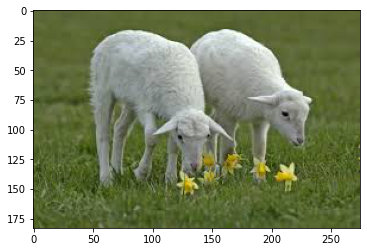

In [38]:
sheep_test_image_path = '../datasets/sheep_goat_classification/class_wise/test/sheeps/1.jpg'
img_load = cv2.imread(sheep_test_image_path)
img_load = cv2.cvtColor(img_load,cv2.COLOR_BGR2RGB)
plt.imshow(img_load)
plt.show()

In [41]:
test_image = prepare_image(sheep_test_image_path)
test_image = test_image[None,:,:,:]
test_image = test_image.cuda()
ps=torch.exp(model(test_image))
topconf, topclass = ps.topk(1, dim=1)

In [42]:
print("Sheep" if topclass == 1 else "Goat")

Sheep


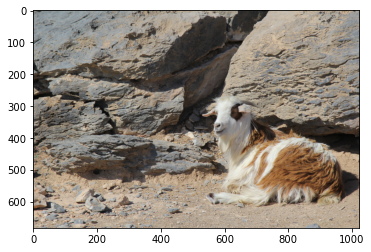

In [43]:
goat_test_image_path = '../datasets/sheep_goat_classification/class_wise/test/goats/1.jpg'
img_load = cv2.imread(goat_test_image_path)
img_load = cv2.cvtColor(img_load,cv2.COLOR_BGR2RGB)
plt.imshow(img_load)
plt.show()

In [44]:
test_image = prepare_image(goat_test_image_path)
test_image = test_image[None,:,:,:]
test_image = test_image.cuda()
ps=torch.exp(model(test_image))
topconf, topclass = ps.topk(1, dim=1)

In [45]:
print("Sheep" if topclass == 1 else "Goat")

Goat
